# FBI Gun Data

The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used by to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from census.gov.

The NICS data is found in one sheet of an .xlsx file. It contains the number of firearm checks by month, state, and type.
The U.S. census data is found in a .csv file. It contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.

## Data reading and check

In [463]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

gun_data = pd.read_csv('gun_data.csv')
US_Census_Data = pd.read_csv('US_Census_Data.csv')

In [464]:
#check the data reading
gun_data.head(2)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303


In [465]:
#summerize parts of data
gun_data['rentals_other'] = 0#fill up broken column
def sum_over_guns(gun_dataframe,column_index):
    '''
    Input:
        gun_dataframe: a pd.Dataframe contains 'xx_handgun', 'xx_long_gun', and 'xx_other' columns.
        column_index: the repeat common index "xx".
    Behavior:
        create new serie to by sum over 'xx_handgun', 'xx_long_gun', and 'xx_other' columns.
    Output:
        sum_over_guns: sum over data in 'xx_handgun', 'xx_long_gun', and 'xx_other'.
    '''
    handgun = column_index + '_handgun'
    long_gun = column_index + '_long_gun'
    other = column_index + '_other'
    sum_over_guns = gun_dataframe[handgun] + gun_dataframe[long_gun] + gun_dataframe[other]
    return sum_over_guns

gun_data_summerize = gun_data.fillna(0)
gun_data_summerize['prepawn'] = sum_over_guns(gun_data_summerize,'prepawn')
gun_data_summerize['redemption'] = sum_over_guns(gun_data_summerize,'redemption')
gun_data_summerize['returned'] = sum_over_guns(gun_data_summerize,'returned')
gun_data_summerize['rentals'] = sum_over_guns(gun_data_summerize,'rentals')
gun_data_summerize['private_sale'] = sum_over_guns(gun_data_summerize,'private_sale')
gun_data_summerize['return_to_seller'] = sum_over_guns(gun_data_summerize,'return_to_seller')

gun_data_summerize = gun_data_summerize.fillna(0)
gun_data_summerize.head(2)#check data columns

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,return_to_seller_long_gun,return_to_seller_other,totals,rentals_other,prepawn,redemption,returned,rentals,private_sale,return_to_seller
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,3.0,32019,0,38.0,2641.0,0.0,0.0,28.0,3.0
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,6303,0,7.0,356.0,58.0,0.0,42.0,0.0


In [466]:
#check the data scale.
gun_data_summerize.shape

(12485, 34)

In [467]:
#check the data scale.
US_Census_Data.shape

(85, 52)

In [468]:
US_Census_Data = US_Census_Data.fillna(0)
US_Census_Data.head(2)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",0,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",0,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"


## Refine and  grouping
To start analysis, we need to refine data. To analysis the following total items.
<ul>
    <li>prepawn and redemption</li>
    <li>returned and rentals</li>
    <li>private_sale and return_to_seller</li>
</ul>
By sum over corresponding handgun, long_gun, and other column.

In [469]:
#By state grouping data.
state_vs_gun = gun_data_summerize.groupby(['state'], as_index = False).sum()
state_vs_gun.head(2)

,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,...,return_to_seller_long_gun,return_to_seller_other,totals,rentals_other,prepawn,redemption,returned,rentals,private_sale,return_to_seller
0,Alabama,1047441.0,749.0,2222037.0,2626029.0,39578.0,105230,32.0,4239.0,6343.0,...,12.0,6.0,6706079,0,10608.0,653892.0,0.0,1.0,450.0,32.0
1,Alaska,13352.0,22.0,434602.0,572174.0,15970.0,28904,19.0,1043.0,1463.0,...,6.0,1.0,1137643,0,2507.0,68682.0,950.0,0.0,451.0,10.0


We find there are no rentals_other column. We add it for convenient. 

In [470]:
state_vs_gun.columns

Index(['state', 'permit', 'permit_recheck', 'handgun', 'long_gun', 'other',
       'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun',
       'prepawn_other', 'redemption_handgun', 'redemption_long_gun',
       'redemption_other', 'returned_handgun', 'returned_long_gun',
       'returned_other', 'rentals_handgun', 'rentals_long_gun',
       'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other', 'totals', 'rentals_other', 'prepawn',
       'redemption', 'returned', 'rentals', 'private_sale',
       'return_to_seller'],
      dtype='object')

## Which states have had the highest growth in gun registrations?
Check the distribution of gun v.s state. We may find which state got most of guns.

Text(0,0.5,'Number of guns')

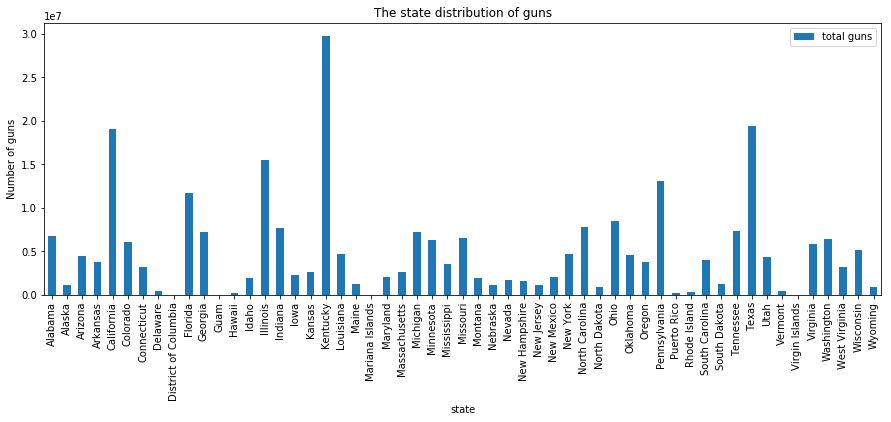

In [504]:
#Plot state v.s. number of total guns.
key_index = ['state', 'totals']
state_vs_gun_total = state_vs_gun.loc[:,key_index]
state_vs_gun_total.columns = ['state', 'total guns']
figure_1_title = 'The state distribution of guns'
ax = state_vs_gun_total.plot(x='state', kind='bar', figsize=(15,5), title = figure_1_title)
ax.set_ylabel('Number of guns')

To simplify the data, we select top 5 states to analysis. First, we check number of guns by time variation.

Text(0,0.5,'Number of guns')

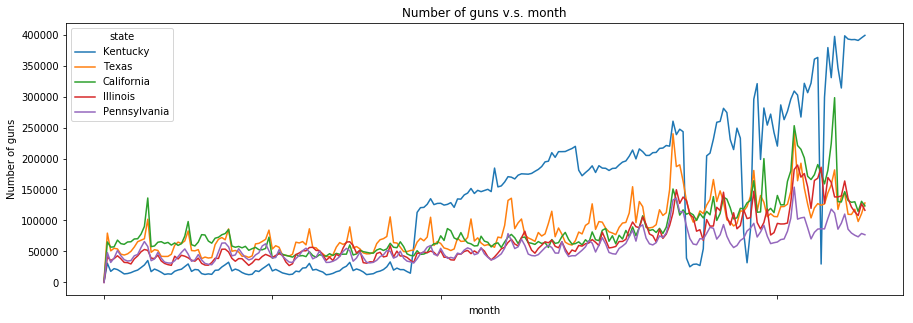

In [505]:
#select top 5 state.
totals_sort = state_vs_gun.sort_values('totals',ascending=False)
top_5_totals_gun_state = totals_sort.iloc[0:5,0]
#plot top 5 state month vs total guns.
gun_data_month_state = gun_data.groupby(['month','state'], as_index = False)
time_vs_totals_gun = gun_data_month_state.sum()
time_vs_totals_gun_reshape = time_vs_totals_gun.pivot(index='month', columns='state', values='totals')
figure_2_title = 'Number of guns v.s. month'
ax = time_vs_totals_gun_reshape.loc[:,top_5_totals_gun_state].plot(kind='line', figsize=(15,5), title = figure_2_title)
ax.set_ylabel('Number of guns')

It is abnormal trend up to Kentucky. To check what distribution of Kentucky.

In [473]:
gun_data_summerize.columns

Index(['month', 'state', 'permit', 'permit_recheck', 'handgun', 'long_gun',
       'other', 'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun',
       'prepawn_other', 'redemption_handgun', 'redemption_long_gun',
       'redemption_other', 'returned_handgun', 'returned_long_gun',
       'returned_other', 'rentals_handgun', 'rentals_long_gun',
       'private_sale_handgun', 'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other', 'totals', 'rentals_other', 'prepawn',
       'redemption', 'returned', 'rentals', 'private_sale',
       'return_to_seller'],
      dtype='object')

Text(0,0.5,'Number of guns')

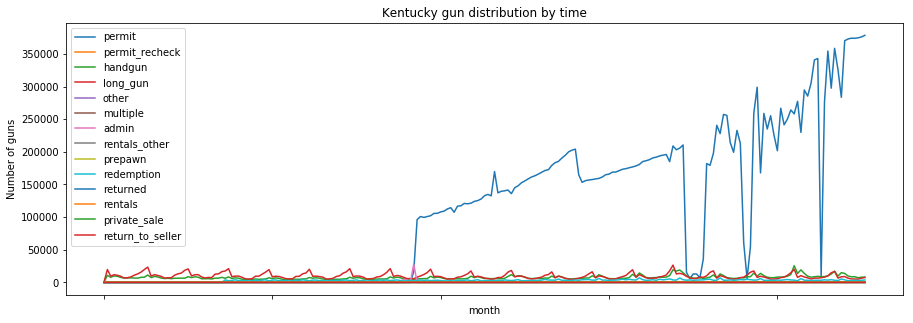

In [506]:
#dorp unnecessary columns.
drop_columns = ['prepawn_handgun', 'prepawn_long_gun', 'prepawn_other', 'redemption_handgun', 
                'redemption_long_gun','redemption_other', 'returned_handgun', 'returned_long_gun',
                'returned_other', 'rentals_handgun', 'rentals_long_gun','private_sale_handgun', 
                'private_sale_long_gun', 'private_sale_other','return_to_seller_handgun', 
                'return_to_seller_long_gun','return_to_seller_other','totals']
gun_data_drop = gun_data_summerize.drop(drop_columns, axis=1)
gun_data_drop_by_month = gun_data_drop.sort_values(by='month')
figure_3_title = 'Kentucky gun distribution by time'
ax = gun_data_drop_by_month.loc[gun_data['state'] == 'Kentucky'].plot(kind='line', x='month', figsize=(15,5), title=figure_3_title)
ax.set_ylabel('Number of guns')

**The trend chart shows that "permit" almost dominates the number of guns in Kentucky, i.e. the highest registration rate.** 

## What is the overall trend of gun purchases?
To check this part, we remove 'permit','permit_recheck' first.

Text(0,0.5,'Number of guns')

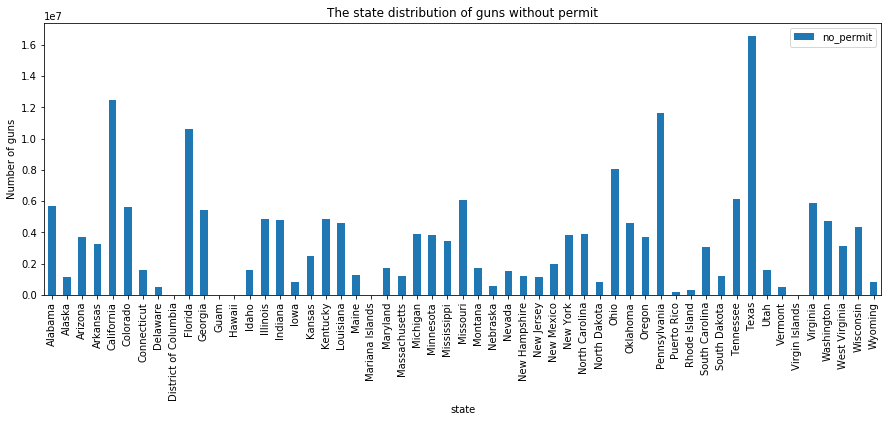

In [507]:
#Find the most dominate state without "permit" noise.
#(note: total - permit - permit_recheck). 
state_vs_gun['no_permit'] = state_vs_gun['totals'] - state_vs_gun['permit'] - state_vs_gun['permit_recheck']
no_permit_index = ['state', 'no_permit']
state_vs_gun_no_permit= state_vs_gun.loc[:,no_permit_index]
figure_4_title = 'The state distribution of guns without permit'
ax = state_vs_gun_no_permit.plot(x='state',kind='bar', figsize=(15,5), title=figure_4_title)
ax.set_ylabel('Number of guns')

It shows that Texas is the newest champion. We check the gun distribution of Texas since it dominate the overall data.

Text(0,0.5,'Number of guns')

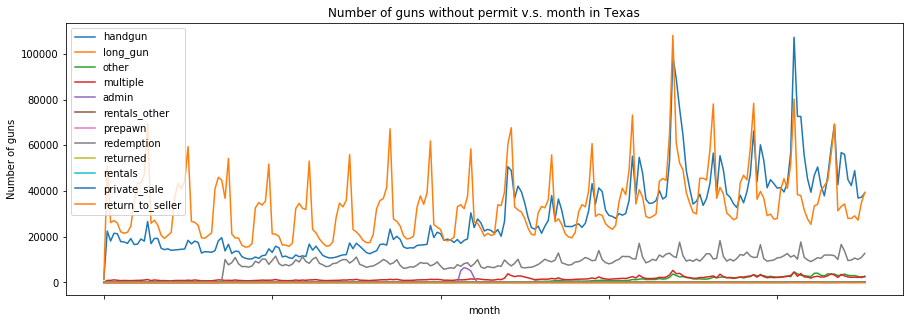

In [508]:
#The detail gun distribution of Texas by time.
gun_data_drop_by_month_no_permit = gun_data_drop_by_month.drop(['permit','permit_recheck'], axis=1)
figure_5_title = 'Number of guns without permit v.s. month in Texas'
ax = gun_data_drop_by_month_no_permit.loc[gun_data['state'] == 'Texas'].plot(kind='line', x='month', figsize=(15,5), title=figure_5_title)
ax.set_ylabel('Number of guns')

This Texas trend chart shows that **the gun purchases of guns trend up periodically**. 
## What is the period of number of guns increase in Texas?
Since the number of handgun and long gun dominate the trend chart. We may as what period of the time. To check it, we isolate the handgun and long gun column.

In [477]:
#Extract Texas handgun and long_gun data
gun_dominate_columns = ['month','handgun','long_gun']
Time_vs_Texas_gun = gun_data_drop_by_month_no_permit.loc[gun_data['state'] == 'Texas',gun_dominate_columns]
Time_vs_Texas_gun.head(3)

,month,handgun,long_gun
12476,1998-11,1384.0,1349.0
12421,1998-12,22478.0,50899.0
12366,1999-01,18123.0,26179.0


Since month column is string, it hard to calculate. We need to label a new index.

Text(0,0.5,'Frequncy weight')

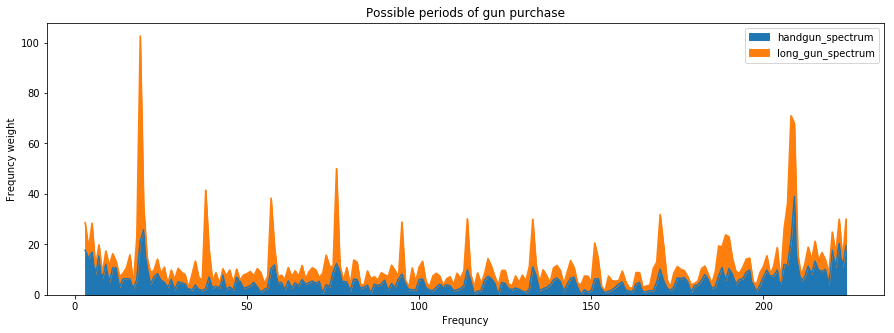

In [509]:
#Sperate to numpy array
order = 10**5
handgun_and_time = np.array(Time_vs_Texas_gun['handgun'])/order
long_gun_and_time = np.array(Time_vs_Texas_gun['long_gun'])/order
#Do FFT find max month frequency.
handgun_frqency = np.fft.fft(np.exp(2j * np.pi * handgun_and_time))
long_gun_frqency = np.fft.fft(np.exp(2j * np.pi * long_gun_and_time))
#Adding absolute values column.
gun_frqency = pd.DataFrame()
gun_frqency['handgun_spectrum'] = np.absolute(handgun_frqency)
gun_frqency['long_gun_spectrum'] = np.absolute(long_gun_frqency)
N = len(gun_frqency)
trivial_frequency_region = 3
gun_frqency['Frequncy'] = np.arange(N)
gun_frqency_refine = gun_frqency.loc[trivial_frequency_region:N-trivial_frequency_region]
#Plot data
figure_5_title = 'Possible periods of gun purchase'
ax = gun_frqency_refine.plot(kind='area', x='Frequncy', figsize=(15,5), title=figure_5_title)
ax.set_ylabel('Frequncy weight')

We find that both handgun and long_gun have two peaks.

In [479]:
#Check the main frequecies of the handgun data.
gun_frqency_refine.sort_values('handgun_spectrum', ascending = False).head(3)

,handgun_spectrum,long_gun_spectrum,frequncy
209,39.007352,28.975316,209
20,25.798635,9.300694,20
19,21.311382,81.310095,19


The max frequncy of handgun is 209. It just indicate the number of handgun trend up during this 227 month gun data of Texas. The second frequncy is about 20. It indicate the number of handgun reaches local maxium about 20 month.

In [480]:
#Check the main frequecies of the long gun data.
gun_frqency_refine.sort_values('long_gun_spectrum', ascending = False).head(3)

,handgun_spectrum,long_gun_spectrum,frequncy
19,21.311382,81.310095,19
208,21.298534,49.707765,208
38,2.424076,39.084774,38


So as long gun data, the frequecy 208 just reflect the number of long gun trend up during this statistical period. However, we may notice that the frequecy 19 reaches the max pick. It means the local deviation is more higher than long term trend up. Generally speaking, **19 month is the period, which reflects the number of guns rise and decrease**.
(p.s this is the only way I thought to using numpy in this project. :) )

## The relations between Census
We want to know the correlation between U.S. census and number of no permit guns. First, we need to elaborate the data to better visualization.<br>
What we care is the most no permit guns top three states, which are Texas, California ,and Pennsylvania.

In [481]:
def convert_number(data_input):
    """
    Input:
        data_input: a string data. e.g. %, $,...
    Behavior:
        Convert the strings in US Census to float.
        Ex: 50% => 0.5, $60,333 => 60333
    Output:
        data_output: a float which convert by string.
    """
    if data_input in ['-','D','F','FN','NA','S','X','Z']:
        data_output = 0
    elif '%' in data_input:
        data_output = float(data_input[0:-2])/100
    elif '$' or ',' in data_input:
        data_output = ''
        for char in data_input:
            if (char != '$') and (char !=','):
                data_output += char
        data_output = float(data_output)
    return data_output

In [498]:
#Drop redundant parts
USC_Data_drop = US_Census_Data.drop(US_Census_Data.index[64:])
#Split to classification part and raw data part
US_Census_row_info = USC_Data_drop.iloc[:,0:2]
USC_data_raw = USC_Data_drop.iloc[:,2:]
#Convert raw data
USC_data = USC_data_raw.applymap(convert_number)
USC_data['total'] = USC_data.sum(axis = 1)
USC_data_norm = USC_data.div(USC_data.total,axis = 0)
#Construct the normalize version of USCensus
USCensus = pd.concat([US_Census_row_info, USC_data_norm], axis=1)
USCensus.head(3)#total should be 1.

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,total
0,"Population estimates, July 1, 2016, (V2016)",0,0.015083,0.002301,0.021495,0.009267,0.121726,0.017183,0.011092,0.002953,...,0.020627,0.086410,0.009463,0.001937,0.026087,0.022602,0.005679,0.017921,0.001816,1.0
1,"Population estimates base, April 1, 2010, (V2...",0,0.015512,0.002305,0.020744,0.009463,0.120895,0.016321,0.011598,0.002914,...,0.020594,0.081602,0.008969,0.002031,0.025964,0.021822,0.006013,0.018456,0.001829,1.0
2,"Population, percent change - April 1, 2010 (es...",0,0.008134,0.021531,0.040191,0.011962,0.025837,0.048804,0.000478,0.028708,...,0.022967,0.051675,0.049761,-0.000957,0.024402,0.040191,-0.005742,0.007656,0.018660,1.0


In [488]:
#Extract top 3 states, Texas, California ,and Pennsylvania.
key_columns = ['Fact','Texas','California','Pennsylvania']
USCensus_top3 = USCensus.loc[:,key_columns]
USCensus_top3['others'] = USCensus.total - USCensus_top3.sum(axis = 1)
USCensus_top3.head(3)
#.drop(columns='total')

,Fact,Texas,California,Pennsylvania,others
0,"Population estimates, July 1, 2016, (V2016)",0.086410,0.121726,0.039648,0.752217
1,"Population estimates base, April 1, 2010, (V2...",0.081602,0.120895,0.041222,0.756281
2,"Population, percent change - April 1, 2010 (es...",0.051675,0.025837,0.002871,0.919617


Text(0.5,0,'Percentage')

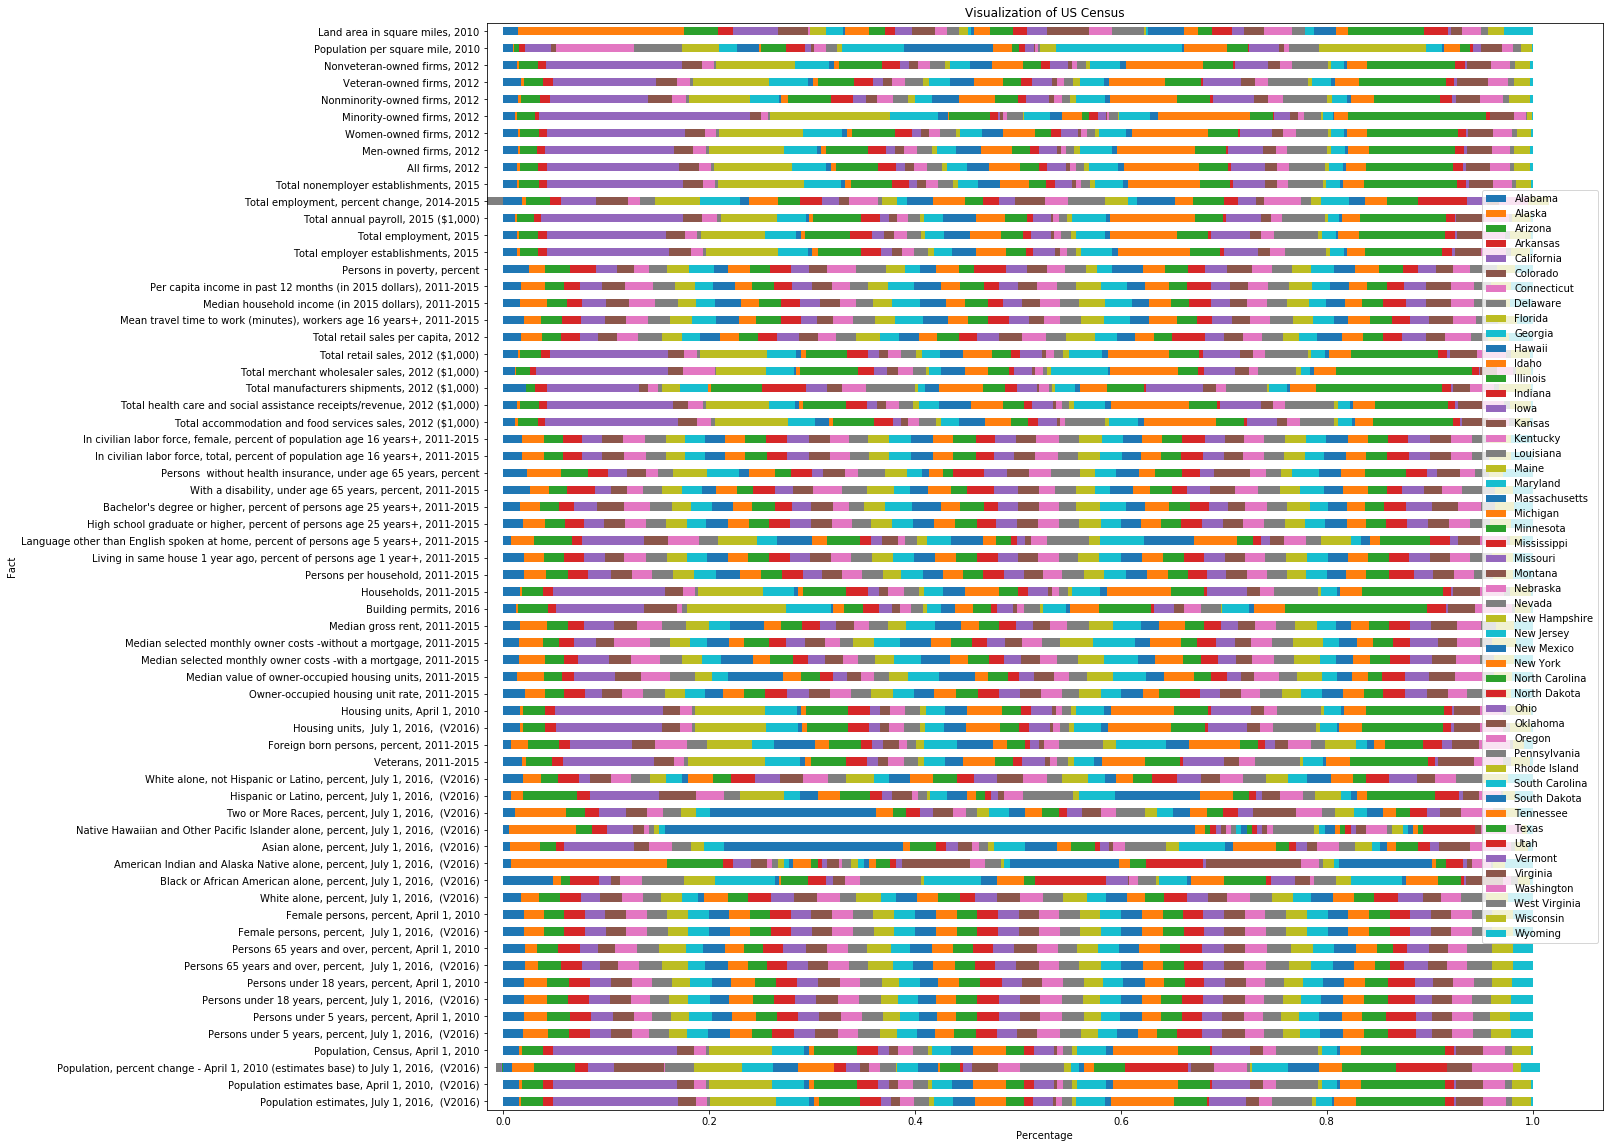

In [516]:
figure_6_title = 'Visualization of US Census'
USCensus_states = USCensus.drop(columns=['total'])
ax = USCensus_states.plot(kind='barh', x = 'Fact',stacked=True, figsize=(20,20), title = figure_6_title)
ax.set_xlabel('Percentage')

In [525]:
USCensus_states.sort_values(by=['Texas'],ascending=False).head(5)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
29,"Building permits, 2016",0,0.012481,0.001250,0.029600,0.007882,0.085153,0.032426,0.004579,0.004829,...,0.004731,0.030082,0.137986,0.018854,0.001473,0.025901,0.036671,0.002117,0.016036,0.001437
58,"Minority-owned firms, 2012",0,0.011633,0.001727,0.017068,0.004539,0.204330,0.010829,0.007078,0.001821,...,0.000517,0.013274,0.135020,0.003081,0.000297,0.023341,0.011707,0.000729,0.005110,0.000514
43,"Total merchant wholesaler sales, 2012 ($1,000)",(c),0.011094,0.001002,0.013339,0.006005,0.128069,0.014799,0.031114,0.001081,...,0.003921,0.021462,0.132793,0.005941,0.001239,0.016639,0.016005,0.002746,0.014805,0.001075
42,"Total manufacturers shipments, 2012 ($1,000)",(c),0.021882,0.000000,0.008984,0.010995,0.089817,0.008844,0.009671,0.003962,...,0.002960,0.024538,0.123180,0.008774,0.001633,0.016899,0.023060,0.004305,0.031159,0.001891
54,"Total nonemployer establishments, 2015",0,0.013266,0.002287,0.018618,0.008172,0.132109,0.019808,0.011238,0.002502,...,0.002637,0.020420,0.090840,0.008910,0.002485,0.023746,0.018296,0.003631,0.014086,0.001983


In [530]:
USCensus_states.sort_values(by=['Texas']).head(5)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
16,Native Hawaiian and Other Pacific Islander alo...,(a),0.005051,0.065657,0.015152,0.015152,0.025253,0.010101,0.005051,0.005051,...,0.005051,0.005051,0.005051,0.050505,0.000000,0.005051,0.040404,0.000000,0.005051,0.005051
62,"Population per square mile, 2010",0,0.009684,0.000123,0.005775,0.005745,0.024528,0.004975,0.075717,0.047271,...,0.001098,0.015788,0.009879,0.003447,0.006965,0.020784,0.010382,0.007909,0.010771,0.000595
14,"American Indian and Alaska Native alone, perce...",(a),0.007007,0.152152,0.054054,0.010010,0.017017,0.016016,0.005005,0.006006,...,0.090090,0.004004,0.010010,0.016016,0.004004,0.005005,0.019019,0.002002,0.011011,0.027027
19,"White alone, not Hispanic or Latino, percent, ...",0,0.018984,0.017657,0.016013,0.021033,0.010877,0.019792,0.019533,0.018148,...,0.023803,0.021408,0.012291,0.022735,0.026861,0.018003,0.020052,0.026630,0.023572,0.024264
17,"Two or More Races, percent, July 1, 2016, (V2...",0,0.010870,0.049592,0.019022,0.013587,0.025815,0.020380,0.015625,0.017663,...,0.015625,0.012908,0.012908,0.016984,0.012908,0.019701,0.031250,0.011549,0.012908,0.014266


Sorting the max values of Texas. We find that the following fact is higher in Texas.<br>
<ul>
    <li>Building permits.</li>
    <li>Minority-owned firms.</li>
    <li>Total merchant wholesaler sales.</li>
    <li>Total manufacturers shipments.</li>
    <li>Total nonemployer establishments.</li>
</ul>
We also find the following fact lower than others.<br>
<ul>
    <li>Native Hawaiian and Other Pacific Islander alone.</li>
    <li>Population per square mile.</li>
    <li>American Indian and Alaska Native alone.</li>
    <li>White alone, not Hispanic or Latino.</li>
    <li>Two or More Races.</li>
</ul>

## Conclusion
From the previous analysis, we may conclude that Texas has the following properties:
<ul>
    <li>low population density.</li>
    <li>Multi-races.</li>
    <li>High percentage people live alone.</li>
    <li>High nonemployer establishment.</li>
</ul>
These may infer that **people need guns for self-defense because it is hard to find neighbors or relatives to help each other**. However, **the U.S. Census only show the difference between states. It doesn't provide detail ratio of population** in Texas. It may need more specific data indicate the social structure of Texas to find what kinds of people usually buy guns, and why they want to buy guns.